In [1]:
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
%matplotlib inline

/home/tomek/ib_insync/.env/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
contract = pd.read_pickle('minute_NQ0919_non_active_included.pickle')
multiplier = 20
min_tick = 0.25

In [3]:
periods = [10, 20, 40, 80, 160,] # 320] # number of periods for breakout rule
ema_fast = 80 # number of periods for moving average filter
sl_atr = 1 # stop loss in ATRs
time_int = 30 # interval in minutes to be used to define volume candle

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

9881.436770634415

In [5]:
#vol_candles = group_by_time(contract, time_int)
vol_candles = group_by_volume(contract, avg_vol)
data = pd.DataFrame(vol_candles.close)
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()

In [6]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

In [7]:
def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).round(0)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
  

In [8]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

In [9]:
signals['value'] = signals['close'] * signals['signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

In [10]:
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, 80)

In [11]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * sl_atr
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [12]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [13]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(1615.5, 1078.75, 2694.25)

In [14]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(943, 783, 0.5463499420625724)

In [15]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(9063.75, -6369.5, 1.4229923855875657)

In [16]:
pnl_m.sort_values().head(20)

label
2288   -48.25
1247   -32.25
1281   -32.25
1588   -30.25
1423   -29.75
1168   -27.25
1405   -27.00
873    -26.75
1426   -26.75
2292   -26.25
2110   -26.00
1236   -26.00
1930   -25.50
1407   -25.25
1444   -25.25
1549   -25.00
1440   -25.00
1573   -24.75
2232   -24.75
1773   -24.50
Name: pnl, dtype: float64

In [17]:
pnl_p.sort_values(ascending=False).head(20)

label
1419    97.50
387     90.00
1422    51.00
1182    41.75
1228    40.50
55      38.75
1235    38.75
1164    38.00
1546    37.50
1771    36.25
1786    36.25
2229    34.75
65      33.50
1788    33.00
1163    32.50
391     32.50
1925    31.75
1446    31.50
1230    31.50
872     31.25
Name: pnl, dtype: float64

In [18]:
signals['date'] = vol_candles['date']

In [19]:
signals.set_index('date', inplace=True)

In [20]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-09-02,7621.50,-15.25
2019-09-03,7614.25,-12.50
2019-09-04,7723.75,60.75
2019-09-05,7859.00,133.00
2019-09-06,7870.50,5.50


In [21]:
daily.head()

,close,pnl
date,,
2019-05-02,7770.0,0.0
2019-05-03,NaN,0.0
2019-05-04,NaN,0.0
2019-05-05,NaN,0.0
2019-05-06,NaN,0.0


In [22]:
daily['dollars'] = 0
daily.iloc[0,2] = 25000

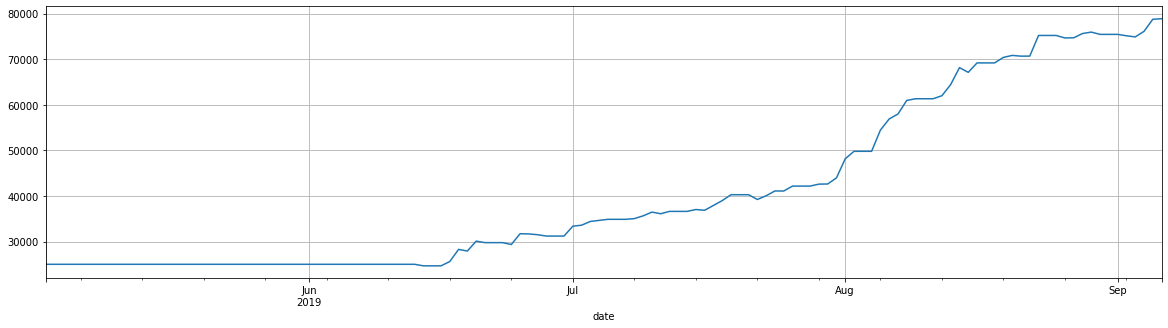

In [23]:
daily['dollars'] = 25000 + daily.pnl.cumsum() * multiplier
daily['return'] = daily.dollars.pct_change()
daily.dollars.plot(figsize=(20,5), grid=True);

In [24]:
perf_stats(daily['return'])

Annual return            8.605354
Cumulative returns       2.155400
Annual volatility        0.358379
Sharpe ratio             6.561642
Calmar ratio           331.614948
Stability                0.910987
Max drawdown            -0.025950
Omega ratio              9.066137
Sortino ratio           37.972840
Skew                          NaN
Kurtosis                      NaN
Tail ratio               6.392336
Daily value at risk     -0.035820
dtype: float64

In [25]:
number_of_trades

288

In [26]:
spread = min_tick * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

2024.6399999999999

In [27]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

127

In [28]:
trades_per_day = number_of_trades / days
trades_per_day

2.267716535433071

In [29]:
pnl_in_dollars = pnl*multiplier

In [30]:
cost_of_trades / (pnl_in_dollars)

0.03757335065417092

In [31]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(2.35155513014385, 0.35837904412692484)

In [32]:
mean/std

6.56164239701196

In [33]:
#daily.to_pickle('nq_return.pickle')